<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install sklearn-lvq

In [343]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn_lvq import GlvqModel
from sklearn_lvq.utils import plot2d
from sklearn.mixture import GaussianMixture
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
import statsmodels.api as sm
from sklearn_lvq import GlvqModel
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

In [327]:
#Para acomodar la información si viene por minuto y en registros, 
#df = pd.read_csv('rg1.csv')
## aqui agrupamos por minuto
#df_grouped_multiple = df.groupby(['YEAR','MONTH','DAY','HOUR']).agg({'RG1': ['mean']})
#df_grouped_multiple.columns = ['rg1_mean']
#df_grouped_multiple = df_grouped_multiple.reset_index()
## aquí pivoteamos
#df1 = df_grouped_multiple.pivot(index=['YEAR','MONTH','DAY'], columns='HOUR', values='rg1_mean').dropna()
#print(df1) #df1.to_csv('res.csv')
#df1.columns = [['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17', '18','19', '20', '21', '22', '23']]

In [328]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
def print_serie(serie_,title_,):
    fig, ax1 = plt.subplots(figsize=(7,4))
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel('horas', color=LETRASNARA, fontsize='large')
    ax1.set_ylabel('radiación solar', color=LETRASNARA, fontsize='large')
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)    
    for p in serie_:
        plt.plot(p,alpha=0.4)
    plt.show()

In [ ]:
df = pd.read_csv('rg1_horas.csv')
#df = df.query("MONTH=='1' and MONTH=='2' and MONTH=='3'")
df = df[(df.MONTH==12)|(df.MONTH==1)|(df.MONTH==2)]
print(df.head())
horas_ = ['6','7','8','9','10','11','12','13','14','15','16','17']
X = df[horas_].to_numpy()
x_total   = df[['SUMA']].to_numpy()
dx_total  = df[['dSUMA']].to_numpy()
ddx_total = df[['ddSUMA']].to_numpy()

#Normalizing the data
#sc = StandardScaler()
#X = sc.fit_transform(X)
#y = sc.fit_transform(Y)

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test = train_test_split(X, test_size=.5)#

print_serie(X_train,'X_train')
#print_serie(X_test,'X_test')

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(x_total,alpha=1,color='blue')
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(dx_total,alpha=1,color='red')
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(ddx_total,alpha=1,color='green')
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(dx_total, lags=10)
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(ddx_total, lags=10)
plt.show()

# **K-means**


[0 1 3 2 8 8 2 3 9 9 1 5 2 4 3 8 4 8 9 4 9 1 0 8 6 1 1 7 4 0 7 8 6 0 1 2 1
 7 1 2 1 8 8 9 8 1 4 8 7 6 1 0 1 1 3 7 4 1 0 4 1 9 7 7 3 9 0 0 8 9 7 1 1 0
 4 7 3 7 7 9 1 8 0 1 9 4 3 1 0]


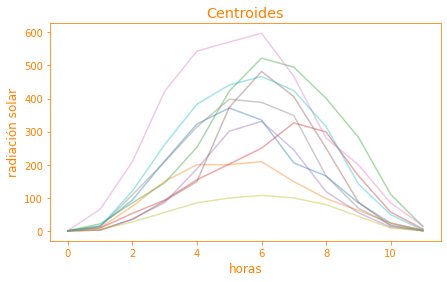

In [386]:
n_clusters = 10
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10) # una variante MiniBatchKMeans  
k_means = k_means.fit(X_train)
values  = k_means.cluster_centers_.squeeze()
labels  = k_means.labels_
centers_= k_means.cluster_centers_
#print('Centroides', centers_)
#print('Exactitud:', k_means.score(X_test))
y_pred = k_means.predict(X_test)
print(y_pred)
print_serie(centers_,'Centroides')

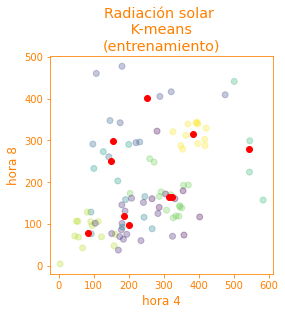

<class 'numpy.ndarray'>


In [387]:
def scatterplot(X_,Y_,tags_,centers_,title_,namefile_ ):
    fig, ax1 = plt.subplots(figsize=(4,4))
    CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
    for k in centers_:
        x = k[4]; y = k[8]
        plt.plot(x,y,"o",color="red",)
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel('hora 4',  color=LETRASNARA, fontsize='large')
    ax1.set_ylabel('hora 8',  color=LETRASNARA, fontsize='large')
    plt.scatter(X_, Y_, c=tags_, alpha=0.3)
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)
    plt.savefig(namefile_, transparent=True)
    plt.show()

scatterplot(X_train[:,4],X_train[:,8],labels,centers_,'Radiación solar \n K-means \n(entrenamiento)','fig_t13_train')
#scatterplot(  X_test[:, 7], X_test[:, 8],y_pred,centers_,'Radiación solar \n K-means \n(prueba)',       'fig_t13_test')
print(type(labels))

# **LVQ**

In [394]:
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_rslvq.html
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/index.html
#https://mrnuggelz.github.io/sklearn-lvq/modules/generated/sklearn_lvq.GlvqModel.html#sklearn_lvq.GlvqModel
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_glvq.html#sphx-glr-auto-examples-plot-glvq-py

nb_ppc = 100
print('GLVQ:')

glvq = GlvqModel(prototypes_per_class=5, initial_prototypes=None, max_iter=2500, gtol=1e-05)
glvq.fit(X_train,labels)
x_pred = glvq.predict(X_test)

print('classification accuracy:', glvq.score(X_test, y_pred))
plt.show()

GLVQ:
classification accuracy: 0.8314606741573034


In [389]:
print(x_pred)

[1 1 3 2 8 8 2 4 9 9 1 5 2 4 3 8 4 8 9 4 9 1 0 8 6 1 1 7 1 0 7 8 9 0 1 2 1
 7 1 6 1 8 8 6 8 4 4 8 7 6 1 1 1 1 1 7 4 1 0 1 1 2 7 9 5 9 0 0 8 9 7 1 1 0
 1 7 7 7 7 9 4 8 0 1 9 4 4 1 0]


# **GaussianMixture**

In [395]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
#https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
# fit a Gaussian Mixture Model with two components
gm = GaussianMixture(n_components=n_clusters, covariance_type="full")
gm.fit(X_train)

print(gm.predict(X_test))

print('classification accuracy:', gm.score(X_test, y_pred))


[8 4 8 8 4 4 8 4 8 8 4 8 5 4 5 8 8 4 8 4 8 4 8 4 8 4 8 8 8 8 8 4 8 8 4 4 4
 8 8 8 4 4 8 8 4 4 4 4 8 8 8 4 4 4 4 8 8 8 8 4 8 8 8 5 4 5 4 4 4 8 8 4 4 8
 4 8 4 8 8 8 8 8 8 4 8 4 4 8 8]
classification accuracy: -479.91993281808016


# **KNN**

In [ ]:
#https://scikit-learn.org/stable/modules/neighbors.html#classification
nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_train)  #['auto','ball_tree','kd_tree','brute'].
distances, indices = nbrs.kneighbors(X_train)
print(distances, indices)
nbrs.kneighbors_graph(X_train).toarray()

In [398]:
neigh = KNeighborsClassifier(n_neighbors=8)
neigh.fit(X_train, labels)
print(neigh.predict(X_test))
print(neigh.predict_proba(X_test))
neigh.score(X_test,x_pred)

[1 1 3 2 8 8 9 1 9 9 1 5 9 1 3 8 4 8 9 1 9 1 0 8 9 1 1 7 1 0 7 8 9 0 1 9 1
 7 1 2 1 8 8 9 8 1 4 8 7 9 1 1 1 1 1 7 4 1 0 1 1 9 7 9 5 9 0 0 8 9 7 1 1 0
 1 7 7 7 7 9 1 8 0 1 9 1 1 1 7]
[[0.375 0.5   0.    0.    0.125 0.    0.    0.    0.    0.   ]
 [0.    1.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.125 0.125 0.125 0.375 0.25  0.    0.    0.    0.    0.   ]
 [0.    0.    0.625 0.    0.    0.375 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.25  0.    0.    0.    0.125 0.    0.    0.625]
 [0.    0.375 0.    0.    0.25  0.    0.    0.    0.375 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.125 0.    0.875]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.25  0.75  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.125 0.    0.125 0.5   0.    0.25  0.    0.   ]
 [0.    0.    0.125 0.    0.    0.    0.    0.    0.    0.875]

0.8089887640449438